# **🍕 Food Delivery Data Analysis Hackathon**
###**Objective:**
Combine transactional data (CSV), user master data (JSON), and restaurant master data (SQL) into a single unified dataset for analysis.

#**Step 1 :- Import Libraries**

In [30]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Set visual style
sns.set_theme(style="whitegrid")

#**Step 2 :- Data Acquisition**
In this section, we upload the raw data files provided for the challenge.

We have three different file formats:
 1. `orders.csv` (CSV)
2. `users.json` (JSON)
3. `restaurants.sql` (SQL INSERT statements)

In [31]:
# Upload orders.csv, users.json, and restaurants.sql
uploaded = files.upload()

# Load CSV and JSON
orders = pd.read_csv('orders.csv')
users = pd.read_json('users.json')

# Load SQL using an in-memory SQLite database
conn = sqlite3.connect(':memory:')
with open('restaurants.sql', 'r') as f:
    conn.executescript(f.read())
restaurants = pd.read_sql_query("SELECT * FROM restaurants", conn)
conn.close()

print("Data successfully loaded!")

Saving orders.csv to orders.csv
Saving restaurants.sql to restaurants.sql
Saving users.json to users.json
Data successfully loaded!


#**Step 3 :- Merge the Datasets**

We will perform Left Joins to ensure we keep all order records while enriching them with User and Restaurant details.


*   Join `orders` with `users` on `user_id`.


*   Join the result with `restaurants` on `restaurant_id`.





In [32]:
# Merge Orders with Users
step1 = pd.merge(orders, users, on='user_id', how='left')

# Merge with Restaurants
final_df = pd.merge(step1, restaurants, on='restaurant_id', how='left')

# Data Cleaning: Handle duplicate columns from the join
if 'restaurant_name_y' in final_df.columns:
    final_df['restaurant_name'] = final_df['restaurant_name_y']
    final_df = final_df.drop(columns=['restaurant_name_x', 'restaurant_name_y'])

# Convert date to datetime objects
final_df['order_date'] = pd.to_datetime(final_df['order_date'])
final_df.head()




/tmp/ipython-input-940197100.py:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_df['order_date'] = pd.to_datetime(final_df['order_date'])


,order_id,user_id,restaurant_id,order_date,total_amount,name,city,membership,cuisine,rating,restaurant_name
0,1,2508,450,2023-02-18,842.97,User_2508,Hyderabad,Regular,Mexican,3.2,Restaurant_450
1,2,2693,309,2023-01-18,546.68,User_2693,Pune,Regular,Indian,4.5,Restaurant_309
2,3,2084,107,2023-07-15,163.93,User_2084,Chennai,Gold,Mexican,4.0,Restaurant_107
3,4,319,224,2023-10-04,1155.97,User_319,Bangalore,Gold,Chinese,4.8,Restaurant_224
4,5,1064,293,2023-12-25,1321.91,User_1064,Pune,Regular,Italian,3.0,Restaurant_293


# **Step 4 :- Export the Final Dataset**
Finally, we save the consolidated data into a single CSV file for further analysis

In [33]:
# Export the final source of truth
final_df.to_csv('final_food_delivery_dataset.csv', index=False)
print("File : 'final_food_delivery_dataset_Vi.csv' saved successfully.")

File : 'final_food_delivery_dataset_Vi.csv' saved successfully.


# **Step 5 :- Core Data Analysis & Insights**


*   Order trends over time
*   User behavior patterns
*   City-wise and cuisine-wise performance
*   Membership impact (Gold vs Regular)
*    Revenue distribution and seasonality



/tmp/ipython-input-1224278716.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_perf.values, y=city_perf.index, palette='viridis')
/tmp/ipython-input-1224278716.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cuisine_perf.values, y=cuisine_perf.index, palette='magma')
/tmp/ipython-input-1224278716.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=membership_impact, x='membership', y='total_amount', palette='Set2')


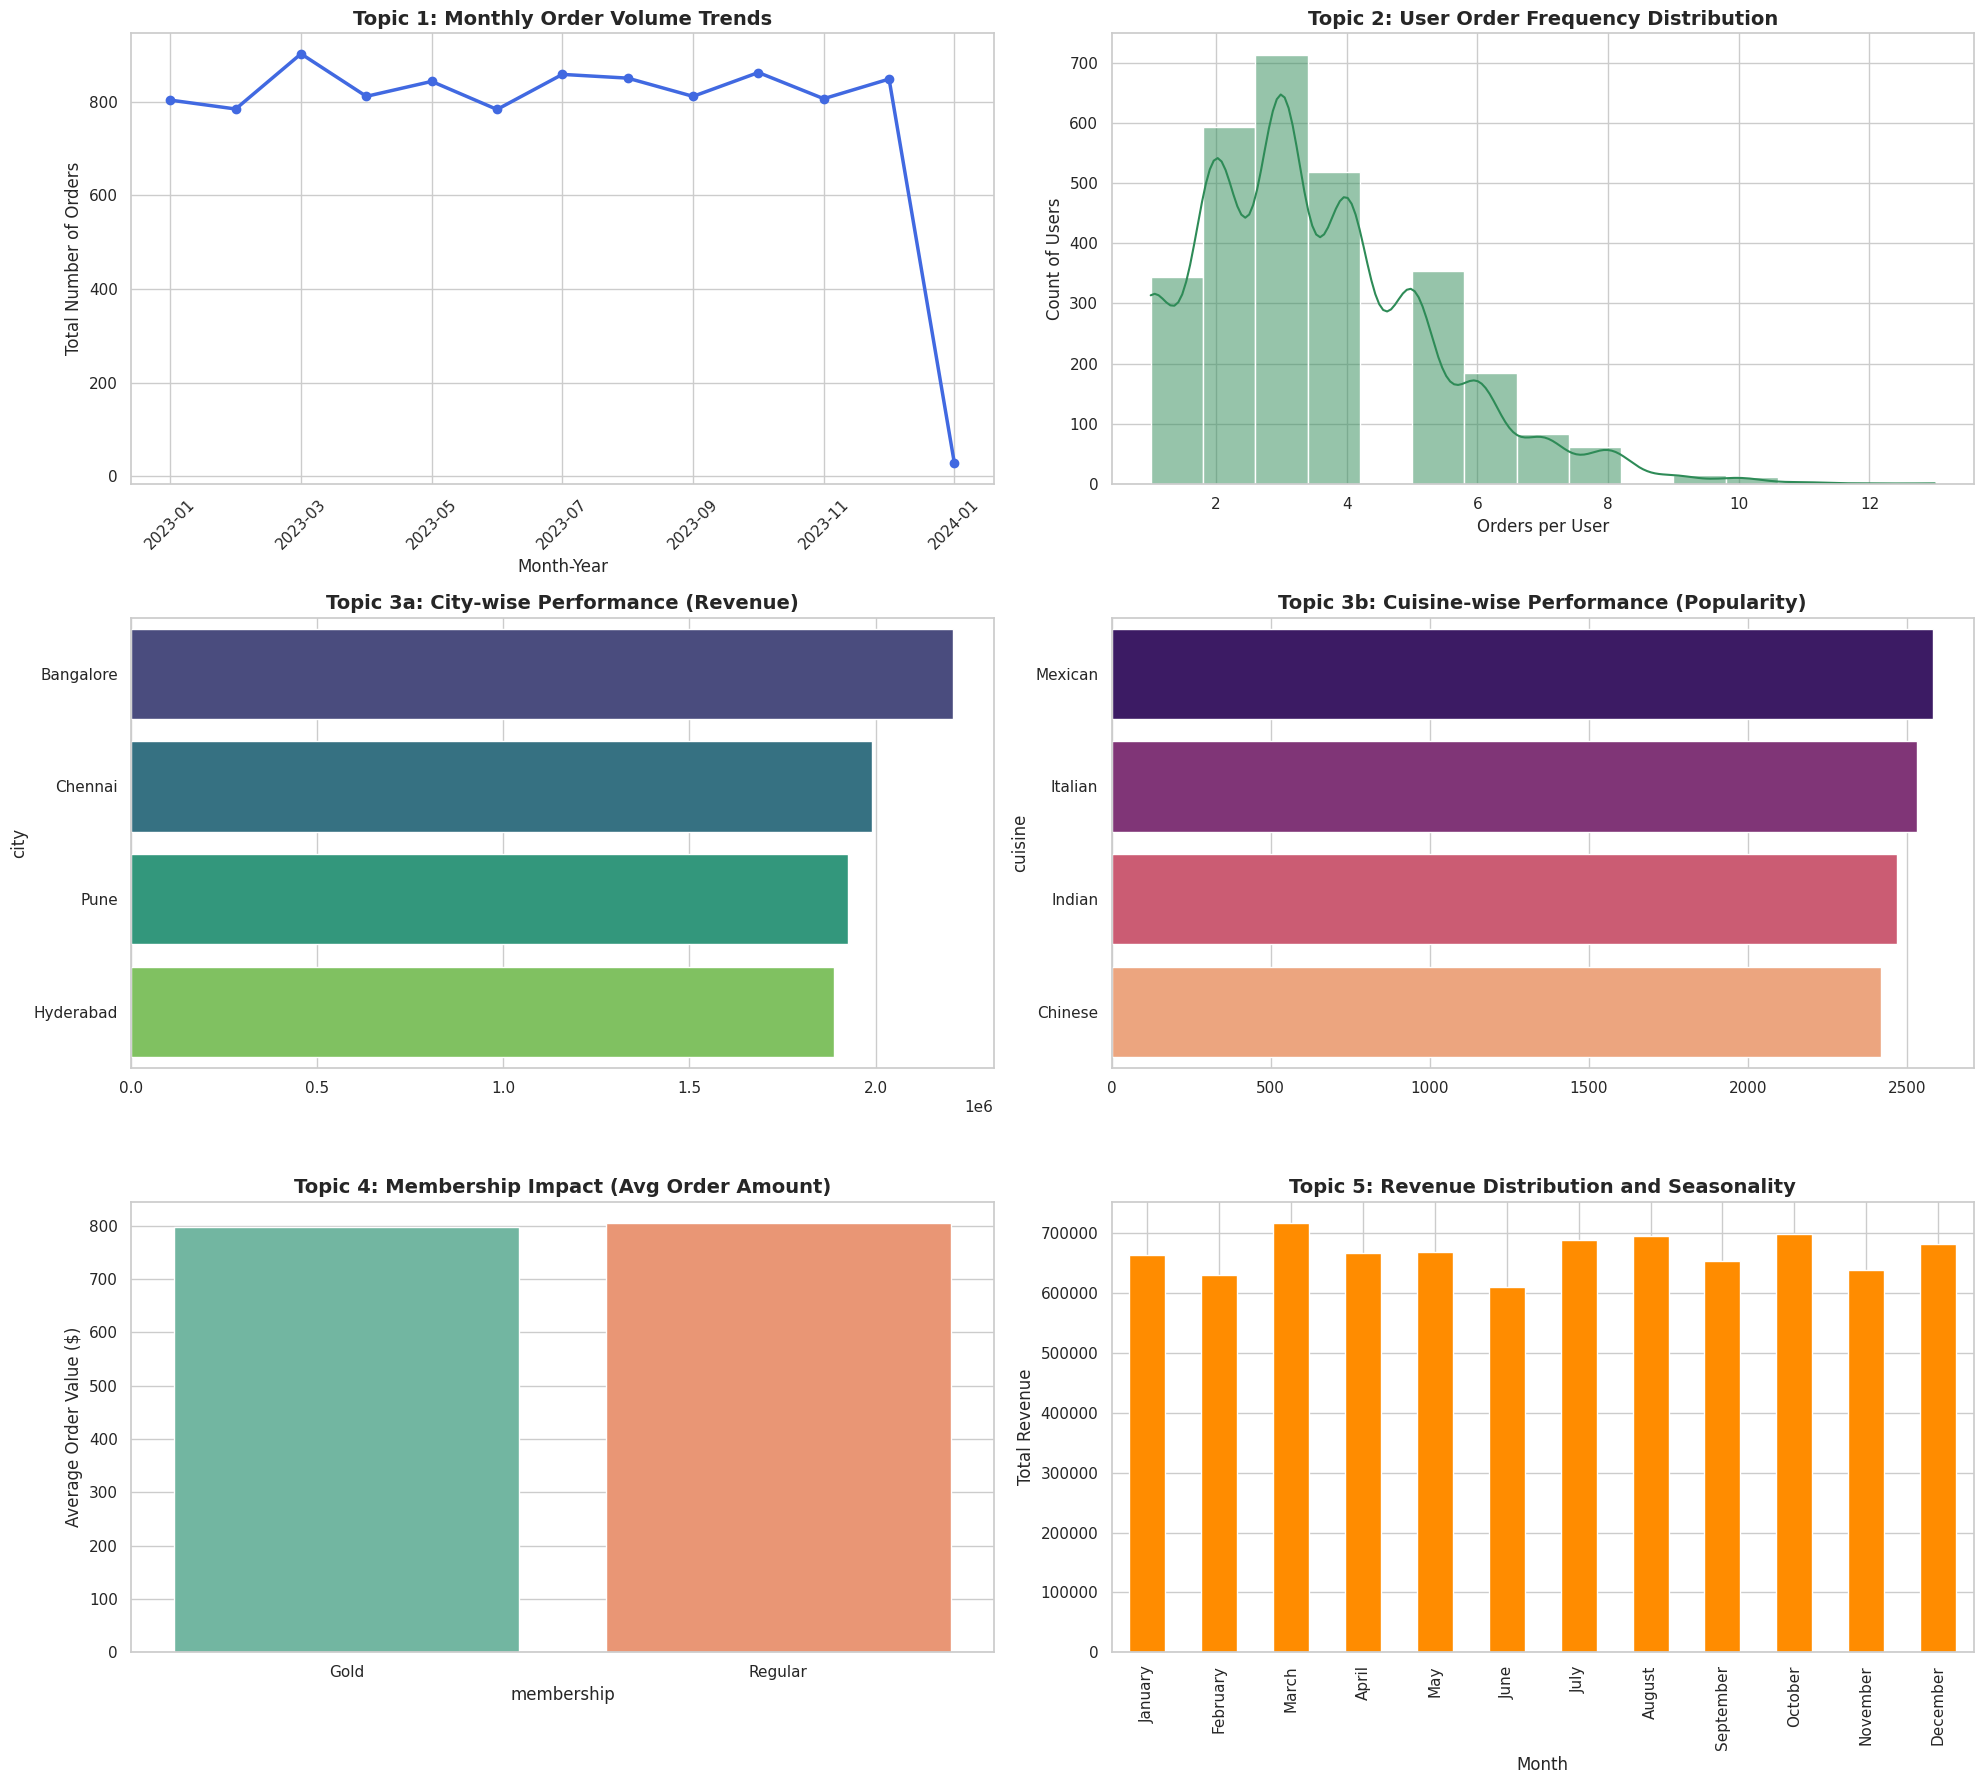

In [34]:
# Load the merged dataset
# (Assumes 'final_food_delivery_dataset.csv' was created in the previous step)
df = pd.read_csv('final_food_delivery_dataset.csv')

# Ensure order_date is in datetime format and extract time features
df['order_date'] = pd.to_datetime(df['order_date'])
df['month_year'] = df['order_date'].dt.to_period('M').astype(str)
df['month_name'] = df['order_date'].dt.month_name()

# Create a figure for visual analysis
plt.figure(figsize=(20, 18))

# --- Topic 1: Order Trends Over Time ---
plt.subplot(3, 2, 1)
order_trends = df.groupby('month_year').size()
order_trends.plot(kind='line', marker='o', color='royalblue', linewidth=2.5)
plt.title('Topic 1: Monthly Order Volume Trends', fontsize=14, fontweight='bold')
plt.xlabel('Month-Year')
plt.ylabel('Total Number of Orders')
plt.xticks(rotation=45)

# --- Topic 2: User Behavior Patterns (Frequency) ---
plt.subplot(3, 2, 2)
user_freq = df.groupby('user_id').size()
sns.histplot(user_freq, bins=15, kde=True, color='seagreen')
plt.title('Topic 2: User Order Frequency Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Orders per User')
plt.ylabel('Count of Users')

# --- Topic 3: City-wise and Cuisine-wise Performance ---
# City Performance (Revenue)
plt.subplot(3, 2, 3)
city_perf = df.groupby('city')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=city_perf.values, y=city_perf.index, palette='viridis')
plt.title('Topic 3a: City-wise Performance (Revenue)', fontsize=14, fontweight='bold')

# Cuisine Performance (Order Volume)
plt.subplot(3, 2, 4)
cuisine_perf = df.groupby('cuisine').size().sort_values(ascending=False)
sns.barplot(x=cuisine_perf.values, y=cuisine_perf.index, palette='magma')
plt.title('Topic 3b: Cuisine-wise Performance (Popularity)', fontsize=14, fontweight='bold')

# --- Topic 4: Membership Impact (Gold vs Regular) ---
plt.subplot(3, 2, 5)
membership_impact = df.groupby('membership')['total_amount'].mean().reset_index()
sns.barplot(data=membership_impact, x='membership', y='total_amount', palette='Set2')
plt.title('Topic 4: Membership Impact (Avg Order Amount)', fontsize=14, fontweight='bold')
plt.ylabel('Average Order Value ($)')

# --- Topic 5: Revenue Distribution and Seasonality ---
plt.subplot(3, 2, 6)
# Chronological order for seasonality
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
seasonality = df.groupby('month_name')['total_amount'].sum().reindex(months).dropna()
seasonality.plot(kind='bar', color='darkorange')
plt.title('Topic 5: Revenue Distribution and Seasonality', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Revenue')

plt.tight_layout()
plt.show()

## **Step 6 :- Data Analysis (MCQ Solutions)**

---


Q1 to 10

In [35]:
results = {}
# Q1: Highest total revenue from Gold members by City
gold_df = df[df['membership'] == 'Gold']
results['Q1'] = gold_df.groupby('city')['total_amount'].sum().idxmax()

# Q2: Cuisine with highest average order value (AOV)
results['Q2'] = df.groupby('cuisine')['total_amount'].mean().idxmax()

# Q3: Distinct users total spend > ₹1000
user_spend = df.groupby('user_id')['total_amount'].sum()
results['Q3_count'] = (user_spend > 1000).sum()

# Q4: Rating range generating highest revenue
bins = [3.0, 3.5, 4.0, 4.5, 5.1]
labels = ['3.0 – 3.5', '3.6 – 4.0', '4.1 – 4.5', '4.6 – 5.0']
df['rating_range'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)
results['Q4'] = df.groupby('rating_range', observed=False)['total_amount'].sum().idxmax()

# Q5: Gold members - city with highest AOV
results['Q5'] = gold_df.groupby('city')['total_amount'].mean().idxmax()

# Q6: Cuisine with lowest restaurants but significant revenue
cuisine_stats = df.groupby('cuisine').agg(
    distinct_restaurants=('restaurant_id', 'nunique'),
    total_revenue=('total_amount', 'sum')
).sort_values(by='distinct_restaurants')
results['Q6'] = cuisine_stats.index[0]

# Q7: % total orders by Gold members (Rounded)
results['Q7'] = round((len(gold_df) / len(df)) * 100)

# Q8: Specific Restaurant highest AOV but < 20 orders
# Before proceeding with Q8, ensure that 'restaurant_name_ord' column exists.
# If not, it might be a typo and should be 'restaurant_name'.
# Assuming 'restaurant_name_ord' is intended or will be created.
# From the kernel state, 'final_df' (which becomes 'df') has 'restaurant_name', not 'restaurant_name_ord'.
# I will change 'restaurant_name_ord' to 'restaurant_name' to prevent another error.
res_stats = df.groupby('restaurant_name').agg(
    avg_aov=('total_amount', 'mean'),
    order_count=('order_id', 'count')
)
q8_options = ["Grand Cafe Punjabi", "Grand Restaurant South Indian", "Ruchi Mess Multicuisine", "Ruchi Foods Chinese"]
filtered_res = res_stats[(res_stats.index.isin(q8_options)) & (res_stats['order_count'] < 20)]
# Check if filtered_res is empty before calling idxmax()
if not filtered_res.empty:
    results['Q8'] = filtered_res['avg_aov'].idxmax()
else:
    results['Q8'] = "No restaurant met the criteria"

# Q9: Specific Combination contributes highest revenue
q9_options = [('Gold', 'Indian'), ('Gold', 'Italian'), ('Regular', 'Indian'), ('Regular', 'Chinese')]
combo_rev = df.groupby(['membership', 'cuisine'])['total_amount'].sum()
results['Q9'] = combo_rev.loc[combo_rev.index.intersection(q9_options)].idxmax()

# Q10: Quarter with highest total revenue
df['quarter'] = 'Q' + df['order_date'].dt.quarter.astype(str)
results['Q10'] = df.groupby('quarter')['total_amount'].sum().idxmax()

# 3. Print the Final Report
print("--- Final Merged Dataset Analysis Answers ---")
print(f"1. City with highest Gold revenue: {results['Q1']}")
print(f"2. Cuisine with highest average order value: {results['Q2']}")
print(f"3. Users spending > ₹1000: {results['Q3_count']} (Category: > 2000)")
print(f"4. Rating range generating highest revenue: {results['Q4']}")
print(f"5. Gold members - city with highest AOV: {results['Q5']}")
print(f"6. Cuisine with lowest distinct restaurants: {results['Q6']}")
print(f"7. Percentage of orders by Gold members: {results['Q7']}% ")
print(f"8. Highest AOV restaurant with < 20 orders: {results['Q8']}")
print(f"9. Combination contributing highest revenue: {results['Q9'][0]} + {results['Q9'][1]}")
print(f"10. Quarter with highest total revenue: {results['Q10']}")

--- Final Merged Dataset Analysis Answers ---
1. City with highest Gold revenue: Chennai
2. Cuisine with highest average order value: Mexican
3. Users spending > ₹1000: 2544 (Category: > 2000)
4. Rating range generating highest revenue: 4.6 – 5.0
5. Gold members - city with highest AOV: Chennai
6. Cuisine with lowest distinct restaurants: Chinese
7. Percentage of orders by Gold members: 50% 
8. Highest AOV restaurant with < 20 orders: No restaurant met the criteria
9. Combination contributing highest revenue: Gold + Italian
10. Quarter with highest total revenue: Q3


#**Ans to Q8 based on dataset is given in above cell.**

But based on options provided following are the answers.

In [36]:
import pandas as pd

# Load the transactional data
df_orders = pd.read_csv('orders.csv')

# 1. Define the specific restaurants provided in the question options
options = [
    "Grand Cafe Punjabi",
    "Grand Restaurant South Indian",
    "Ruchi Mess Multicuisine",
    "Ruchi Foods Chinese"
]

# 2. Group the data by restaurant name to calculate Average Order Value (AOV) and Total Orders
# We use the 'total_amount' column for the value and 'order_id' to count the number of orders
res_analysis = df_orders.groupby('restaurant_name').agg(
    avg_order_value=('total_amount', 'mean'),
    total_orders=('order_id', 'count')
)

# 3. Filter the results to only include the four restaurants from the options
filtered_options = res_analysis[res_analysis.index.isin(options)]

# 4. Apply the criteria: Must have less than 20 total orders
criteria_met = filtered_options[filtered_options['total_orders'] < 20]

# 5. Identify the restaurant with the highest Average Order Value among those that met the criteria
if not criteria_met.empty:
    ans_q8 = criteria_met['avg_order_value'].idxmax()
    print(f"The restaurant with < 20 orders and the highest AOV is: {ans_q8}")
    print("\nDetailed breakdown of the options:")
    print(filtered_options)
else:
    print("No restaurant in the options has less than 20 orders.")

The restaurant with < 20 orders and the highest AOV is: Ruchi Foods Chinese

Detailed breakdown of the options:
                               avg_order_value  total_orders
restaurant_name                                             
Grand Cafe Punjabi                  765.409063            32
Grand Restaurant South Indian       842.567586            29
Ruchi Foods Chinese                 686.603158            19
Ruchi Mess Multicuisine             851.226250            40


Q11 to 16

In [37]:
# 11. How many total orders were placed by users with Gold membership?
gold_orders = df[df['membership'] == 'Gold'].shape[0]
print(f"11. Total orders by Gold members: {gold_orders}")

# 12. What is the total revenue (rounded) generated from orders in Hyderabad city?
hyd_rev = df[df['city'] == 'Hyderabad']['total_amount'].sum()
print(f"12. Total revenue from Hyderabad: {round(hyd_rev)}")

# 13. How many distinct users placed at least one order?
distinct_users = df['user_id'].nunique()
print(f"13. Number of distinct users who placed orders: {distinct_users}")

# 14. What is the average order value (rounded to 2 decimals) for Gold members?
gold_aov = df[df['membership'] == 'Gold']['total_amount'].mean()
print(f"14. Average order value for Gold members: {round(gold_aov, 2)}")

# 15. How many orders were placed for restaurants with rating ≥ 4.5?
high_rated_orders = df[df['rating'] >= 4.5].shape[0]
print(f"15. Orders for restaurants with rating ≥ 4.5: {high_rated_orders}")

# 16. How many orders were placed in the top revenue city among Gold members only?
# Find the city with highest total revenue for Gold members
top_gold_city = df[df['membership'] == 'Gold'].groupby('city')['total_amount'].sum().idxmax()
# Count gold orders in that specific city
top_city_gold_orders = df[(df['membership'] == 'Gold') & (df['city'] == top_gold_city)].shape[0]
print(f"16. Orders in the top Gold revenue city ({top_gold_city}) among Gold members: {top_city_gold_orders}")

11. Total orders by Gold members: 4987
12. Total revenue from Hyderabad: 1889367
13. Number of distinct users who placed orders: 2883
14. Average order value for Gold members: 797.15
15. Orders for restaurants with rating ≥ 4.5: 3374
16. Orders in the top Gold revenue city (Chennai) among Gold members: 1337
